In [1]:
# import modules for math and distributions
from math import exp
import numpy as np
from scipy.stats import gamma, norm, uniform, bernoulli
import pandas as pd
import statsmodels.api as sm
import rpy2
import patsy
import pdb
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
# required to be able to work with rpy2
%load_ext rpy2.ipython

In [3]:
# define inverse logit (expit) function
def expit(x): return(exp(x)/(1 + exp(x)))

In [4]:
# Initial set up following HD2012
T = 40 # time periods
k = 5 # check-up times
theta = [-0.405, 0.0205, -0.00405]
gam = [-3, 0.05, -1.5, 0.1]

In [5]:
# make a function that does all of the above for an individual
# lower and upper limits for positivity
def sim(T, k, gam, theta, patid=0, lower=0, upper=float("inf")):

    # define lists for holding A, L, U and Y
    A = -1*np.ones(T + 2) # A[-1] (last value) holds A in t = -1
    L = np.zeros(T+1)
    U = np.zeros(T+1)
    Y = -1*np.ones(T + 2)
    eps = np.zeros(T+1)
    lam = np.zeros(T+1) # prob of failure at each time period
    delta = np.zeros(T+1)

    # set the first value of U, U[0], to a 
    # randomly generated value from a uniform
    # distribution a measure of general health
    U[0] = uniform.rvs()
    eps[0] = norm.rvs(0, 20)
    L[0] = gamma.ppf(U[0], 3, scale=154) + eps[0]
    # L[0] = max(0, gamma.ppf(U[0], 3, scale=154) + eps[0])

    # set A[-1] to 0: held in last value of A
    A[-1] = 0
    Y[0] = 0
    
    #### EXTRA if here ####
    # set A[0]: If L[0] is less than lower, greater than upper change A[0]
    if L[0] <= lower:
        A[0] = 1
    elif L[0] >= upper:
        A[0] = 0
    else:
        A[0] = bernoulli.rvs(expit(theta[0] + theta[2] * (L[0] - 500)), size=1)

    
    if A[0] == 1:
        Ts = 0 
    else:
        Ts = -1
    
    lam[0] = expit(gam[0] + gam[2] * A[0])
    
    if lam[0] >= U[0]:
        Y[1] = 1
    else:
        Y[1] = 0
    # loop through each time period - stop when patient is dead or t = T + 1
    for t in range(1, T+1):
        if Y[t] == 0:
            delta[t] = norm.rvs(0, 0.05)
            U[t] = min(1, max(0, U[t-1] + delta[t]))
            if t % k != 0:
                L[t] = L[t-1]
                A[t] = A[t-1]
            else:
                eps[t] = norm.rvs(100 * (U[t] - 2), 50)
                L[t] = max(0, L[t-1] + 150 * A[t-k] * (1-A[t-k-1]) + eps[t])
                if A[t-1] == 0:
                    #### EXTRA IF HERE ####
                    if L[t] <= lower:
                        A[t] = 1
                    elif L[t] >= upper:
                        A[t] = 0
                    else:
                        A[t] = bernoulli.rvs(expit(theta[0] + theta[1] * t + theta[2] * (L[t] - 500)), size=1)
                else:
                    A[t] = 1
                if A[t] == 1 and A[t-k] == 0: 
                    Ts = t
            ########################################
            # This is a check for debugging purposes
            # Comment it before the next push
            #if Ts == -1:
            #    if A[t]:
            #        print('There is an error...')
            ########################################
            lam[t] = expit(gam[0] + gam[1] * ((1 - A[t]) * t + A[t] * Ts) + gam[2] * A[t] + gam[3] * A[t] *(t - Ts))
            if (1 - np.prod(1 - lam)) >= U[0]:
                Y[t + 1] = 1
            else:
                Y[t+1] = 0
        else:
            break
    
    #we only need the data before death, so whatever value t is before the end of the
    #above loop - change this to numpy array and transpose.
    Y = np.ndarray.tolist(Y[1:(t+1)])
    U = np.ndarray.tolist(U[0:t])
    L = np.ndarray.tolist(L[0:t])
    A = np.ndarray.tolist(A[0:t])
    Ts = [Ts]*t

    df = np.vstack((Y, L, U, A, Ts))
    df = pd.DataFrame(df.T, columns=['Y', 'L', 'U', 'A', 'Ts'])
    df['Y'] = df['Y'].astype(int)
    df['A'] = df['A'].astype(int)
    df['patid'] = patid
    df.index.name = 'visit'
    return df.reset_index()

# Positivity Plot

Choose values of upper and lower to create a stratum of CD4 count (L) in which a patient never commences treatment, or always commences treatment.
The default is lower = 0 and upper = inf which is the no positivity case. Later in this notebook we look at positivity where introduce positivity into the data and compare the three approaches under the positivity assumption and when it is violated.

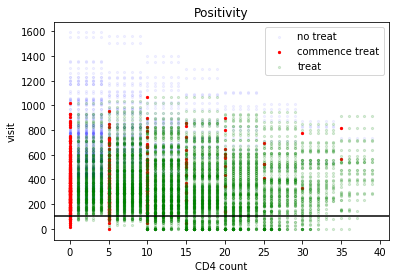

In [6]:
n = 500
lower = 100
upper = float("inf")
frames = [sim(T, k, gam, theta, patid=i, lower=lower, upper=upper) for i in range(n)]
tmp = pd.concat(frames)
tmp = tmp.set_index(['patid', 'visit'])
tmp = tmp.sort_index()
tmp["status"] = tmp.groupby(level="patid")['A'].cumsum()
tmp["status"] = np.where(tmp["status"] == 0, 0, tmp["status"])
tmp["status"] = np.where(tmp["status"] == 1, 1, tmp["status"])
tmp["status"] = np.where(tmp["status"] > 1, 2, tmp["status"])
tmp = tmp.reset_index()

# plot for each status
uniq = list(set(tmp['status']))
label = ["no treat", "commence treat", "treat"]
color = ["blue", "red", "green"]
alpha = [.05, 1, 0.15]
for i in range(len(uniq)):
    indx = tmp['status'] == uniq[i]
    plt.scatter(tmp.loc[indx, "visit"], tmp.loc[indx, "L"],
                s = 5, label=label[i], alpha = alpha[i],
               color = color[i])

plt.axhline(y=upper, color='black', linestyle='-')
plt.axhline(y=lower, color='black', linestyle='-')
plt.xlabel('CD4 count')
plt.ylabel('visit')
plt.title('Positivity')
plt.legend(loc=1)
plt.show()

In [7]:
# use sim function to make a pandas DF for n patients
def get_sim_data(T, k, gam, theta, n = 1000, lower=0, upper=float("inf")):

    # get data for each of 1000 patients
    frames = [sim(T, k, gam, theta, patid=i, lower=lower, upper=upper) for i in range(n)]
    df = pd.concat(frames)
    # make new variables for the logit regression
    # including an intercept
    df["d1"] = (1-df['A'])*df['visit'] + df['A']*df['Ts']
    df["d3"] = df['A']*(df['visit']-df['Ts'])
    # df["time_Ts"] = df["visit"] - df["Ts"]
    df = df.set_index(['patid', 'visit'])
    df = df.sort_index()
    
    #create two new variables 
    df["L_100"] = df["L"]/100
    def func(x):
        x["Lav_100"] = x["L"].mean()/100
        return x

    df = df.groupby(level="patid").apply(func)
    
    # get the previous value of A, and set first value of A_1 per patient to zero.
    df['A_1'] = df.groupby(level="patid")['A'].shift(1)
    df['A_1'] = df['A_1'].fillna(0)

    return(df)

In [8]:
def get_weights(df):
    
    # only need data when A is not 1 yet
    df["As"] = df.groupby(level="patid")['A'].cumsum()
    df2 = df[df["As"] <= 1].copy(deep=True)

    # numerator
    f = "A ~ 1"
    y, X = patsy.dmatrices(f, df2.reset_index(), return_type = "dataframe")
    n_logit = sm.Logit(y, X, missing="raise")
    n_result = n_logit.fit(disp=0, maxiter=100)
    df2["pn"] = n_result.predict()
    
    # denominator
    f = "A ~ L"
    y, X = patsy.dmatrices(f, df2.reset_index(), return_type = "dataframe")
    d_logit = sm.Logit(y, X, missing="raise")
    d_result = d_logit.fit(disp=0, maxiter=100)
    df2["pd"] = d_result.predict()

    # if A == 0, change probabilities to 1 - prob
    df2['pn2'] = np.where(df2['A']==0, (1 - df2["pn"]), df2["pn"])
    df2['pd2'] = np.where(df2['A']==0, (1 - df2["pd"]), df2["pd"])

    # construct stabilized weights, don't forget to group by
    df2['cpn'] = df2.groupby(level=0)['pn2'].cumprod()
    df2['cpd'] = df2.groupby(level=0)['pd2'].cumprod()
    df2['sw'] = df2['cpn']/df2['cpd']

    #combine df and df2
    df["sw"] = np.nan
    df.loc[df2.index, "sw"] = df2["sw"]
    df["sw"] = df["sw"].fillna(method="pad")
    
    return(df)


In [9]:
# a function to allow us to use the ipw package from R to get weights.
# The numerator and denominator probabilities of the stabilized weights
# are estimated using a coxph model.
import rpy2.robjects as robjects
robjects.r('''
       runreg <- function(tmp){
       library(ipw)
       library(survey)
       tmp$tstart <- tmp$visit - 1
       ipwsw <- ipwtm(exposure = A, family = "survival", # survival model for weights
       numerator = ~ 1, denominator = ~ L,
       id = patid, timevar = visit, tstart = tstart,
       type = "first", data = tmp)
       tmp$ipwsw <- ipwsw$ipw.weights
       #desipw <- svydesign(ids = ~ 1, data = tmp, weights = ~ ipwsw)
       #mdl <- svyglm(Y ~ d1 + A + d3, design = desipw, family = quasibinomial())
       mdl <- glm(Y ~ d1 + A + d3, data = tmp, weights=ipwsw, family=binomial)
       return(coef(mdl))
       }
''')

# "initializes" function
r_runreg = robjects.globalenv['runreg']    

In [10]:
# Monte Carlo of table 1 in Havercroft, Didelez (2012)
B = 100 # number of replications

# define matrices to hold parameters for all four regressions
mc1 = np.zeros((B, 4))
mc2 = np.zeros((B, 5))
mc3 = np.zeros((B, 5))
mc4 = np.zeros((B, 4))

#
for i in range(B):
    
    # generate data
    df = get_sim_data(T, k, gam, theta, n = 1000)
    df = get_weights(df)
    tmp = df.reset_index()
    
    # unweighted regression
    f = "Y ~ 1 + d1 + A + d3"
    y, X = patsy.dmatrices(f, df.reset_index(), return_type = "dataframe")
    mod = sm.Logit(y, X, missing="raise")
    mc1[i] = mod.fit(disp=0).params.values
    
    # adjusted regression 1
    f = "Y ~ 1 + d1 + A + d3 + L_100"
    y, X = patsy.dmatrices(f, df.reset_index(), return_type = "dataframe")
    mod = sm.Logit(y, X, missing="raise")
    mc2[i] = mod.fit().params.values
    
    # adjusted regression 2
    f = "Y ~ 1 + d1 + A + d3 + Lav_100"
    y, X = patsy.dmatrices(f, df.reset_index(), return_type = "dataframe")
    mod = sm.Logit(y, X, missing="raise")
    mc3[i] = mod.fit().params.values
    
    # weighted regression
    mc4[i] = r_runreg(tmp)


Optimization terminated successfully.
         Current function value: 0.136274
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.144113
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.140892
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.147433
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.138661
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.144784
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.140359
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.148654
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.134195
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.140969
  

In [11]:
print(mc1.mean(axis = 0))
print(mc1.std(axis = 0))
print(mc2.mean(axis = 0))
print(mc2.std(axis = 0))
print(mc3.mean(axis = 0))
print(mc3.std(axis = 0))
print(mc4.mean(axis = 0))
print(mc4.std(axis = 0))

[-3.77313461  0.00956854 -0.41269239  0.11323714]
[ 0.11437146  0.00650216  0.12474434  0.00415717]
[-0.2180681   0.07144938 -1.91711851  0.09594156 -0.9756258 ]
[ 0.14214106  0.00832977  0.13663784  0.00653284  0.0307244 ]
[-0.22800366  0.22966688 -2.38013078  0.28609186 -1.37319619]
[ 0.17540605  0.0128419   0.17216258  0.00936133  0.05499155]
[-2.98662533  0.04439619 -1.56410656  0.10840185]
[ 0.10156359  0.00829183  0.1168153   0.00766655]


# Positivity Violation

In [12]:
# Monte Carlo of table 1 in Havercroft, Didelez (2012) with positivity violation
B = 100 # number of replications

# define matrices to hold parameters for all four regressions
mc1_pos = np.zeros((B, 4))
mc2_pos = np.zeros((B, 5))
mc3_pos = np.zeros((B, 5))
mc4_pos = np.zeros((B, 4))

#
for i in range(B):
    
    # generate data
    df = get_sim_data(T, k, gam, theta, n = 1000, lower=400, upper=1000)
    df = get_weights(df)
    tmp = df.reset_index()
    
    # unweighted regression
    f = "Y ~ 1 + d1 + A + d3"
    y, X = patsy.dmatrices(f, df.reset_index(), return_type = "dataframe")
    mod = sm.Logit(y, X, missing="raise")
    mc1_pos[i] = mod.fit(disp=0).params.values
    
    # adjusted regression 1
    f = "Y ~ 1 + d1 + A + d3 + L_100"
    y, X = patsy.dmatrices(f, df.reset_index(), return_type = "dataframe")
    mod = sm.Logit(y, X, missing="raise")
    mc2_pos[i] = mod.fit().params.values
    
    # adjusted regression 2
    f = "Y ~ 1 + d1 + A + d3 + Lav_100"
    y, X = patsy.dmatrices(f, df.reset_index(), return_type = "dataframe")
    mod = sm.Logit(y, X, missing="raise")
    mc3_pos[i] = mod.fit().params.values
    
    # weighted regression
    mc4_pos[i] = r_runreg(tmp)


Optimization terminated successfully.
         Current function value: 0.132917
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.136682
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.130189
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.132706
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.131753
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.135731
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.136148
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.140262
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.132665
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.

In [13]:
print(mc1_pos.mean(axis = 0))
print(mc1_pos.std(axis = 0))
print(mc2_pos.mean(axis = 0))
print(mc2_pos.std(axis = 0))
print(mc3_pos.mean(axis = 0))
print(mc3_pos.std(axis = 0))
print(mc4_pos.mean(axis = 0))
print(mc4_pos.std(axis = 0))

[-6.11125959 -0.01029791  1.63919327  0.13914036]
[ 0.33309043  0.0082122   0.36293826  0.00510288]
[-1.46136073  0.06125005 -0.96234093  0.10712759 -0.90272032]
[ 0.34485593  0.00986988  0.37440103  0.00728552  0.02505245]
[-1.83601097  0.2016601  -1.08038598  0.29599658 -1.31707904]
[ 0.34541783  0.01305849  0.39255355  0.00915386  0.04446802]
[-6.99490602  0.02108723  2.31089725  0.12150942]
[ 0.63032039  0.01175185  0.64437587  0.00522746]
